# Bayesian negative binomial regression

In [26]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False
}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize


The [negative binomial distribution](http://en.wikipedia.org/wiki/Negative_binomial_distribution) crops up a lot in computational biology, and in particular RNA-sequencing analysis. In an ideal world we might expect the distribution of RNA-seq reads to be Poisson, where the variance equals the mean and the only error comes from sampling alone. However, RNA-seq reads typically display more dispersion than this, which makes the negative binomial (NB) distribution a good choice since it can be thought of as an overdispersed poisson (or a poisson with a gamma-distributed rate). 

Here we consider Bayesian negative binomial regression of the form

$$ y_i \, \; | \, \; \beta_0, \beta_1, x_i, r \sim NB(\mu_i = \beta_0 + \beta_1 x_i, r) $$

where \\(r\\) is known as the _dispersion_ parameter, since the variance may be written as \\( Var(y_i) = \mu_i + \frac{\mu_i^2}{r} \\). We will implement bayesian inference using metropolis-hastings with the parameters \\(\beta_0 = 10\\), \\(\beta_1 = 5\\) and \\(r = 10 \\).

In [27]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import truncnorm
import seaborn as sns
%matplotlib inline

# A brief recap of Metropolis-Hastings and approximate inference

Parameter inference in a Bayesian setting is often concerned with estimating some posterior density \\(p(x)\\). However, if the prior and likelihood are not conjugate to each other then there is no closed-form solution for the posterior as the normalisation factor is intractable. Here the posterior distribution takes the form \\(p(x) = p^\star(x)/Z\\), where we can easily compute \\( p^\star(x) \\) but not \\(Z\\).

In such cases we can use the _Metropolis-Hastings_ algorithm. This builds up a Markov-chain of the variable \\(x\\), the samples of which converge towards the posterior distribution of \\(p(x)\\). It works as follows:

 1. Sample \\(x'\\) from the proposal distribution \\( q(x' | x) \\). This is typically a Gaussian distribution centred around \\(x\\).
 2. Compute the _acceptance ratio_ 
$$ \alpha = \frac{p(x')q(x | x')}{p(x)q(x'|x)} $$
which is essentially the ratio of the probabilities of \\(x'\\) to \\(x\\) normalised by the probability of being there in the first place (i.e. the ratio of \\(q\\)). This last point is important as it is easy to get this the wrong way round.
 3. Accept \\(x'\\) as the next sample in the Markov chain with probability \\( \mathrm{min}(1, \alpha ) \\), otherwise use \\(x\\). In other words, if \\(x'\\) is more probable then always accept it, and even if it is less probable still accept it with probability \\( \alpha \\).
 

First we can generate 150 data points and visualise them:

#  Simulated data

Text(0, 0.5, '$y$')

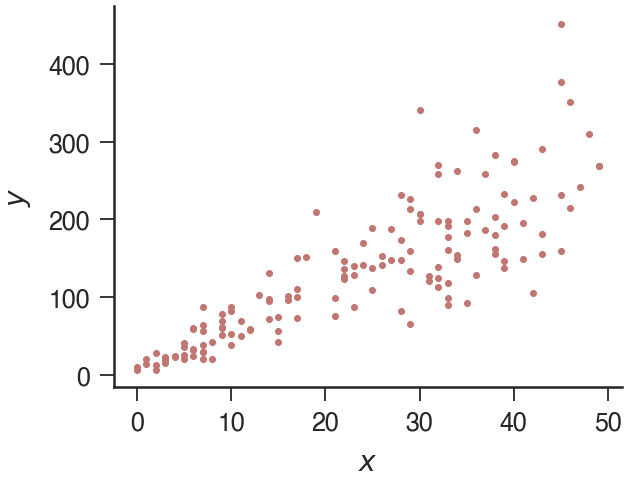

In [28]:
beta_0 = 10
beta_1 = 5

N = 150
x = np.random.randint(0, 50, N)

true_mu = beta_0 + beta_1 * x
true_r = 10
p = 1 - true_mu / (float(true_r) + true_mu)

y = np.random.negative_binomial(n = true_r, p = p, size = N)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
ax.scatter(x, y)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

# Define acceptance ratio and proposal distributions:

In order to implement [metropolis-hastings](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) we need to define proposal distributions for our parameters and compute the acceptance ratio for each move. The proposal distributions for \\(\beta\\) is just a normal centred around the current value, while that for \\(r\\) is a truncated normal centred around the current value. Since these distributions are symmetric (i.e. \\( N(x\,|\,x') = N(x' \, | \, x) \\) ) they do not factor into the acceptance ratio.

For now we place uninformative priors on all the variables, though these can easily be implemented by modifying the acceptance ratio and including hyper-parameters. The regression can also easily be extended to more than one independent variable.

Two parameterizations of the negative binomial distribution exist: $(n,p)$ as per wikipedia and the mean version used for regression with \\( (\mu,r) \\). The equivalence is that \\( r=n \\) and \\( \mu = \frac{pr}{1-p} \\) (though careful how \\(p\\) is defined). It can be shown that the log acceptance ratio is given by

$$
\begin{array}{r}
\alpha = \sum_i \left[ r'\ln\left(\frac{r'}{r' + \mu_i'}\right)  - r\ln\left(\frac{r}{r + \mu_i}\right) + \ln\Gamma(r' + x_i) -\ln\Gamma(r + x_i) + x_i\ln\left(\frac{\mu_i'}{\mu_i}\frac{\mu_i + r}{\mu'_i + r'}\right) \right] + \\
N \left(\ln\Gamma(r) -\ln\Gamma(r')\right)
\end{array}
$$

where

$$ \mu_i = \beta_0 + \beta_1 x_i $$

We also need to define the sampling distributions \\(q(x'|x) \\). Since the parameters are independent we can factorise the expression to 
$$ q(r', \beta_0', \beta_1' \, | r, \beta_0, \beta_1) = q_r(r' \, | r) q_b(\beta_0' \, | \beta_0)$$ 
For \\(q_b\\) we just choose a normal distribution centred around the current value (i.e. \\( q_b \sim N(\beta, \sigma) \\) ), while for \\(q_r) \\) we choose a normal distribution truncated at 0, since the dispersion parameter is strictly positive.

The art of Metropolis-hastings MCMC comes from choosing the variances of the proposal distributions. Too high and the probability of the proposed point will be very small and almost never accepted. Too low and the proposed point will almost always be accepted and it takes far too long for the random walk to fill out the posterior. What MCMC needs is the goldilocks zone - getting the variances just right.

There is a huge body of literature into _adaptive_ MCMC algorithms - those that find the optimal parameters automatically (see e.g. [here](http://probability.ca/jeff/ftpdir/adaptex.pdf)). However, for small problems such as this it can be easier just to play around with the parameters until we get an _acceptance rate_ (proportion of proposed points accepted) to the desired value. Somewhat amazingly [it has been shown](http://projecteuclid.org/euclid.aoap/1034625254) that the optimal acceptance ratio is around 0.44 in a one-parameter problem, and asymptotically approaches 0.234 as the number of parameters increases. Therefore, in our case an acceptance ratio in that region would be desirable.

In [29]:
def nb_acceptance_ratio(theta, theta_p, y, N):
    """ theta = (mu, r), y is data, N = len(x) """
    mu, r = theta
    mu_p, r_p = theta_p
    
    term1 =  r_p * np.log(r_p / (r_p + mu_p))
    term2 = -r * np.log(r / (r + mu))

    term3 = y * np.log(mu_p / mu * (mu + r)/(mu_p + r_p))
    
    term4 = gammaln(r_p + y)
    term5 = - gammaln(r + y)
    
    term6 = N * (gammaln(r) - gammaln(r_p))
    
    return (term1 + term2 + term3 + term4 + term5).sum() + term6

def truncnorm_prop(x, sigma): # proposal for r (non-negative)
    return truncnorm.rvs(-x / sigma, np.Inf, loc=x, scale=sigma)

Before we're ready to run the sampling loop there are two further parameters we need to consider: the burn in of the trace and any thinning we'd like. The burn in is the number of samples to discard at the start of an MCMC run. While typically taken to be half of the samples in total, graphs of autocorrelation can be used to assess the point at which the autocorrelation of the markov chain reaches zero. The second parameter is the thinning, which tells us the proportion of samples to remove from the trace, so if _thin_ = 5 then only every fifth sample is used, which again removes autocorrelation.

# MCMC loop:

In [34]:
n_iter = 10000
burn_in = 4000

sigma_beta_0 = 0.5
sigma_beta_1 = 0.7
sigma_r = 0.5

def calculate_mu(beta, x):
    return beta[0] + beta[1] * x

def metropolis_hastings(n_iter, burn_in, thin=5):
    
    trace = np.zeros((n_iter, 3)) # ordered beta_0 beta_1 r
    trace[0,:] = np.array([5.,5.,1.]) 
    acceptance_rate = np.zeros(n_iter)
    # store previous mu to avoid calculating each time 
    mu = calculate_mu(trace[0,0:2], y) 
    
    for i in range(1, n_iter):
        theta = trace[i-1,:] # theta = (beta_0, beta_1, r)
        
        theta_p = np.array([np.random.normal(theta[0], sigma_beta_0), 
                            np.random.normal(theta[1], sigma_beta_1), 
                            truncnorm_prop(theta[2], sigma_r)]) 
        
        mu_p = calculate_mu(theta_p[0:2], x)
        
        if np.any(mu <= 0):
            print( "mu == 0 on iteration %d" % i)

        alpha = nb_acceptance_ratio((mu, theta[2]), 
                                    (mu_p, theta_p[2]), y, N)
        
        u = np.log(np.random.uniform(0., 1.))

        if u < alpha:
            trace[i,:] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            trace[i,:] = theta
        
            
    print( "Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return trace[burn_in::thin,:]

trace = metropolis_hastings(n_iter, burn_in)

Acceptance rate: 0.25


# Plot traces:

In [31]:
import pandas as pd

In [37]:
trace=pd.DataFrame(trace[:])

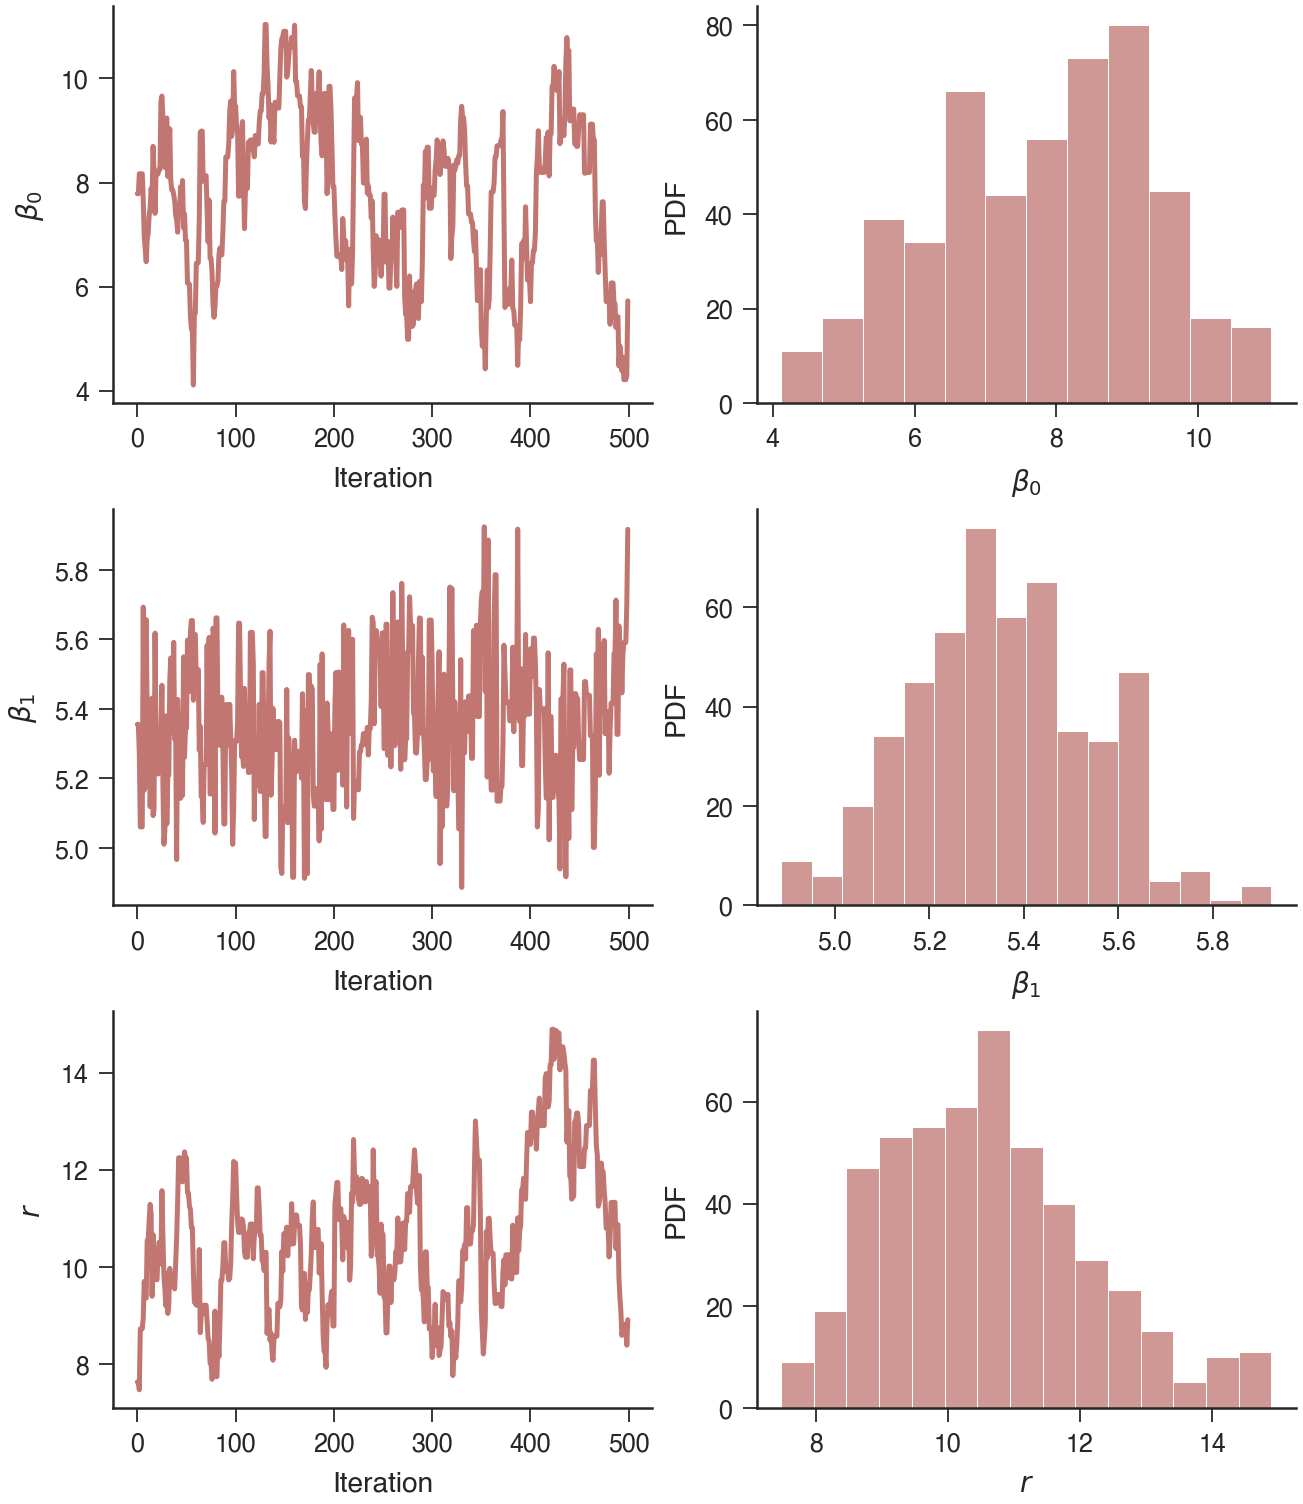

In [39]:
f, axs = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
labels=[r'$\beta_0$',r'$\beta_1$',r'$r$']
count=0
ax=axs.flatten()[0]
ax.plot(trace[0])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[0])

ax=axs.flatten()[1]
sns.histplot(trace[0],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[0])

ax=axs.flatten()[2]
ax.plot(trace[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[1])

ax=axs.flatten()[3]
sns.histplot(trace[1],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[1])

ax=axs.flatten()[4]
ax.plot(trace[2])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[2])

ax=axs.flatten()[5]
sns.histplot(trace[2],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[2])
f.tight_layout()

On the left hand side we can see the traces of the Markov-chain, while on the right we can see the histogram of the posterior. So it seems the posterior captures the true values quite well, given the noise.